In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial

import pydicom
import math
import copy
import glob
import cv2
import os
import os.path
import skimage
import skimage.color
import skimage.transform
import skimage.segmentation
import sklearn.preprocessing
import sklearn.model_selection
import math
import shutil
import pathlib
import random
import torch
import torchvision
import numpy as np
import numpy.matlib
import scipy as sp
import scipy.io
import scipy.signal
import pandas as pd
import imageio
import networkx
import networkx as nx
import datetime
import pywt
import wfdb
import json
import tqdm
import dill
import pickle
import matplotlib.pyplot as plt

import SimpleITK as sitk

import sklearn
import sklearn.decomposition
import cv2

import sak
import sak.hash
import sak.signal.wavelet
import sak.data
import sak.data.augmentation
import sak.visualization
import sak.torch
import sak.torch.nn
import sak.torch.nn as nn
import sak.torch.train
import sak.torch.data
import sak.data.preprocessing

from sak.signal import StandardHeader


def predict(signal, model, window_size=2048, stride=256, thr_dice=0.9, ptg_voting = 0.5, batch_size = 16, normalize=True, norm_threshold=1e-6, percentile=95, filter=False, needsbatch: bool = False):
    if model is None:
        raise ValueError("Model kwarg must not be empty")
    
    # Preprocess signal
    signal = np.copy(signal).squeeze()
    if signal.ndim == 0:
        return np.array([])
    elif signal.ndim == 1:
        signal = signal[:,None]
    elif signal.ndim == 2:
        pass
    else:
        raise ValueError("2 dims max allowed")
        
    # Pad if necessary
    padding = 0
    if signal.shape[0] < window_size:
        padding = math.ceil(signal.shape[0]/window_size)*window_size-signal.shape[0]
        signal = np.pad(signal,((0,padding),(0,0)),mode='edge')
    if (signal.shape[0]-window_size)%stride != 0:
        padding = math.ceil((signal.shape[0]-window_size)/stride)*stride-(signal.shape[0]%window_size)
        signal = np.pad(signal,((0,padding),(0,0)),mode='edge')

    # Get dimensions
    N,L = signal.shape

    # (Optional) Normalize amplitudes
    if normalize:
        signal = signal/(2**15)
        
    # (Optional) Filter signal
    if filter:
        signal = sp.signal.filtfilt(*sp.signal.butter(2,   0.5/250., 'high'),signal,axis=0)
        signal = sp.signal.filtfilt(*sp.signal.butter(2, 150.0/250.,  'low'),signal,axis=0)
        signal = sp.signal.lfilter(*sp.signal.iirnotch(50,20.0,250.),signal,axis=0)
        signal = sp.signal.lfilter(*sp.signal.iirnotch(60,20.0,250.),signal,axis=0)

    # Avoid issues with negative strides due to filtering:
    if np.any(np.array(signal.strides) < 0):
        signal = signal.copy()

    # Check device for segmentation
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Reorder channels
    if signal.shape[0] > signal.shape[1]:
        signal = signal.T
        
    # Compute segmentation for all leads independently
    isolate_zero = False
    segmentation = 0
    with torch.no_grad():
        inputs = {"x": torch.tensor(signal[None,]).float().to(device)}
        if needsbatch and (inputs["x"].shape[0] == 1):
            inputs["x"] = torch.vstack((inputs["x"],inputs["x"]))
            isolate_zero = True

        if isinstance(model,list):
            for m in model:
                m = m.to(device)
                outputs = m(inputs)["sigmoid"].cpu().detach().numpy()
                segmentation += outputs > thr_dice
            segmentation = segmentation >= len(model)*ptg_voting
        else:
            model = model.to(device)
            outputs = model(inputs)["sigmoid"].cpu().detach().numpy()
            segmentation = outputs > thr_dice
    
    if isolate_zero:
        segmentation = segmentation[None,0]
            
#     # Correct padding
#     segmentation = segmentation[0,]
#     if padding > 0:
#         segmentation = segmentation[0,:,:-padding]
            
    # Correct padding
    if padding > 0:
        segmentation = segmentation[:,:,:-padding]
        
    if segmentation.shape[0] == 1:
        segmentation = segmentation[0,]

    return segmentation

def predict_ECG(signal, model, window_size=2048, stride=256, threshold_ensemble: float = 0.5, thr_dice=0.9, percentile=95, ptg_voting = 0.5, batch_size = 16, normalize=True, norm_threshold=1e-6, filter=False):
    # Preprocess signal
    signal = np.copy(signal).squeeze()
    if signal.ndim == 0:
        return np.array([])
    elif signal.ndim == 1:
        signal = signal[:,None]
    elif signal.ndim == 2:
        if signal.shape[0] < signal.shape[1]:
            signal = signal.T
    else:
        raise ValueError("2 dims max allowed")
        
    # Pad if necessary
    if signal.shape[0] < window_size:
        padding = math.ceil(signal.shape[0]/window_size)*window_size-signal.shape[0]
        signal = np.pad(signal,((0,padding),(0,0)),mode='edge')
    if (signal.shape[0]-window_size)%stride != 0:
        padding = math.ceil((signal.shape[0]-window_size)/stride)*stride-(signal.shape[0]%window_size)
        signal = np.pad(signal,((0,padding),(0,0)),mode='edge')

    # Get dimensions
    N,L = signal.shape

    # (Optional) Normalize amplitudes
    if normalize:
        # Get signal when it's not flat zero
        norm_signal = signal[np.all(np.abs(np.diff(signal,axis=0,append=0)) >= norm_threshold,axis=1),:]

        # High pass filter normalized signal to avoid issues with baseline wander
        norm_signal = sp.signal.filtfilt(*sp.signal.butter(2, 0.5/250., 'high'),norm_signal, axis=0)

        # Compute amplitude for those segments
        amplitude = np.array(sak.signal.moving_lambda(
            norm_signal,
            256,
            partial(sak.signal.amplitude,axis=0),
            axis=0
        ))
        amplitude = amplitude[np.all(amplitude > norm_threshold,axis=1),]
        amplitude = np.percentile(amplitude, percentile, axis=0)

        # Apply normalization
        signal = signal/amplitude[None,:]

    # (Optional) Filter signal
    if filter:
        signal = sp.signal.filtfilt(*sp.signal.butter(2,   0.5/250., 'high'),signal,axis=0)
        signal = sp.signal.filtfilt(*sp.signal.butter(2, 125.0/250.,  'low'),signal,axis=0)
        signal = sp.signal.lfilter(*sp.signal.iirnotch(50,20.0,250.),signal,axis=0)
        signal = sp.signal.lfilter(*sp.signal.iirnotch(60,20.0,250.),signal,axis=0)

    # Avoid issues with negative strides due to filtering:
    if np.any(np.array(signal.strides) < 0):
        signal = signal.copy()

    # Data structure for computing the segmentation
    windowed_signal = skimage.util.view_as_windows(signal,(window_size,1),(stride,1))

    # Flat batch shape
    new_shape = (windowed_signal.shape[0]*windowed_signal.shape[1],*windowed_signal.shape[2:])
    windowed_signal = np.reshape(windowed_signal,new_shape)

    # Exchange channel position
    windowed_signal = np.swapaxes(windowed_signal,1,2)

    # Output structures
    windowed_mask = np.zeros((windowed_signal.shape[0],3,windowed_signal.shape[-1]),dtype=int)
    
    # Check device for segmentation
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Compute segmentation for all leads independently
    with torch.no_grad():
        if isinstance(model,list):
            for m in model:
                m = m.to(device)
                for i in range(0,windowed_signal.shape[0],batch_size):
                    inputs = {"x": torch.tensor(windowed_signal[i:i+batch_size]).float().to(device)}
                    outputs = m(inputs)["sigmoid"].cpu().detach().numpy()
                    windowed_mask[i:i+batch_size] += outputs > thr_dice
            windowed_mask = windowed_mask >= len(model)*threshold_ensemble
        else:
            model = model.to(device)
            for i in range(0,windowed_signal.shape[0],batch_size):
                inputs = {"x": torch.tensor(windowed_signal[i:i+batch_size]).to(device).float()}
                outputs = model(inputs)["sigmoid"].cpu().detach().numpy()
                windowed_mask[i:i+batch_size] = outputs > thr_dice

    # Retrieve mask as 1D
    counter = np.zeros((N), dtype=int)
    segmentation = np.zeros((3,N))
        
    # Iterate over windows
    for i in range(0,windowed_mask.shape[0],L):
        counter[(i//L)*stride:(i//L)*stride+window_size] += 1
        segmentation[:,(i//L)*stride:(i//L)*stride+window_size] += windowed_mask[i:i+L].sum(0)
    segmentation = ((segmentation/counter) >= (signal.shape[-1]*ptg_voting))

    # Correct padding
    segmentation = segmentation[:,:-padding]

    return segmentation

models_ECG = [torch.load(f"/media/guille/DADES/DADES/Delineator/TrainedModels/modelos/model.{i+1}") for i in range(5)]

In [3]:
list_files = glob.glob("/media/guille/DADES/DADES/LONG_QT/LongQT_Neonatals/*.XML")

In [4]:
list_files

['/media/guille/DADES/DADES/LONG_QT/LongQT_Neonatals/SJD0366#2009_05_12#05_03_17.XML',
 '/media/guille/DADES/DADES/LONG_QT/LongQT_Neonatals/SJD0001#2017_02_16#10_54_10.XML',
 '/media/guille/DADES/DADES/LONG_QT/LongQT_Neonatals/SJD0001#2017_02_16#10_55_09.XML',
 '/media/guille/DADES/DADES/LONG_QT/LongQT_Neonatals/SJD0002#2017_02_16#11_10_39.XML',
 '/media/guille/DADES/DADES/LONG_QT/LongQT_Neonatals/SJD0003#2017_02_16#11_19_50.XML',
 '/media/guille/DADES/DADES/LONG_QT/LongQT_Neonatals/SJD0003#2017_06_16#15_36_35.XML',
 '/media/guille/DADES/DADES/LONG_QT/LongQT_Neonatals/SJD0004#2017_02_16#11_28_58.XML',
 '/media/guille/DADES/DADES/LONG_QT/LongQT_Neonatals/SJD0004#2017_02_16#11_29_42.XML',
 '/media/guille/DADES/DADES/LONG_QT/LongQT_Neonatals/SJD0005#2017_02_16#11_33_07.XML',
 '/media/guille/DADES/DADES/LONG_QT/LongQT_Neonatals/SJD0006#2017_02_16#11_45_05.XML',
 '/media/guille/DADES/DADES/LONG_QT/LongQT_Neonatals/SJD0007#2017_02_16#11_53_23.XML',
 '/media/guille/DADES/DADES/LONG_QT/LongQT_

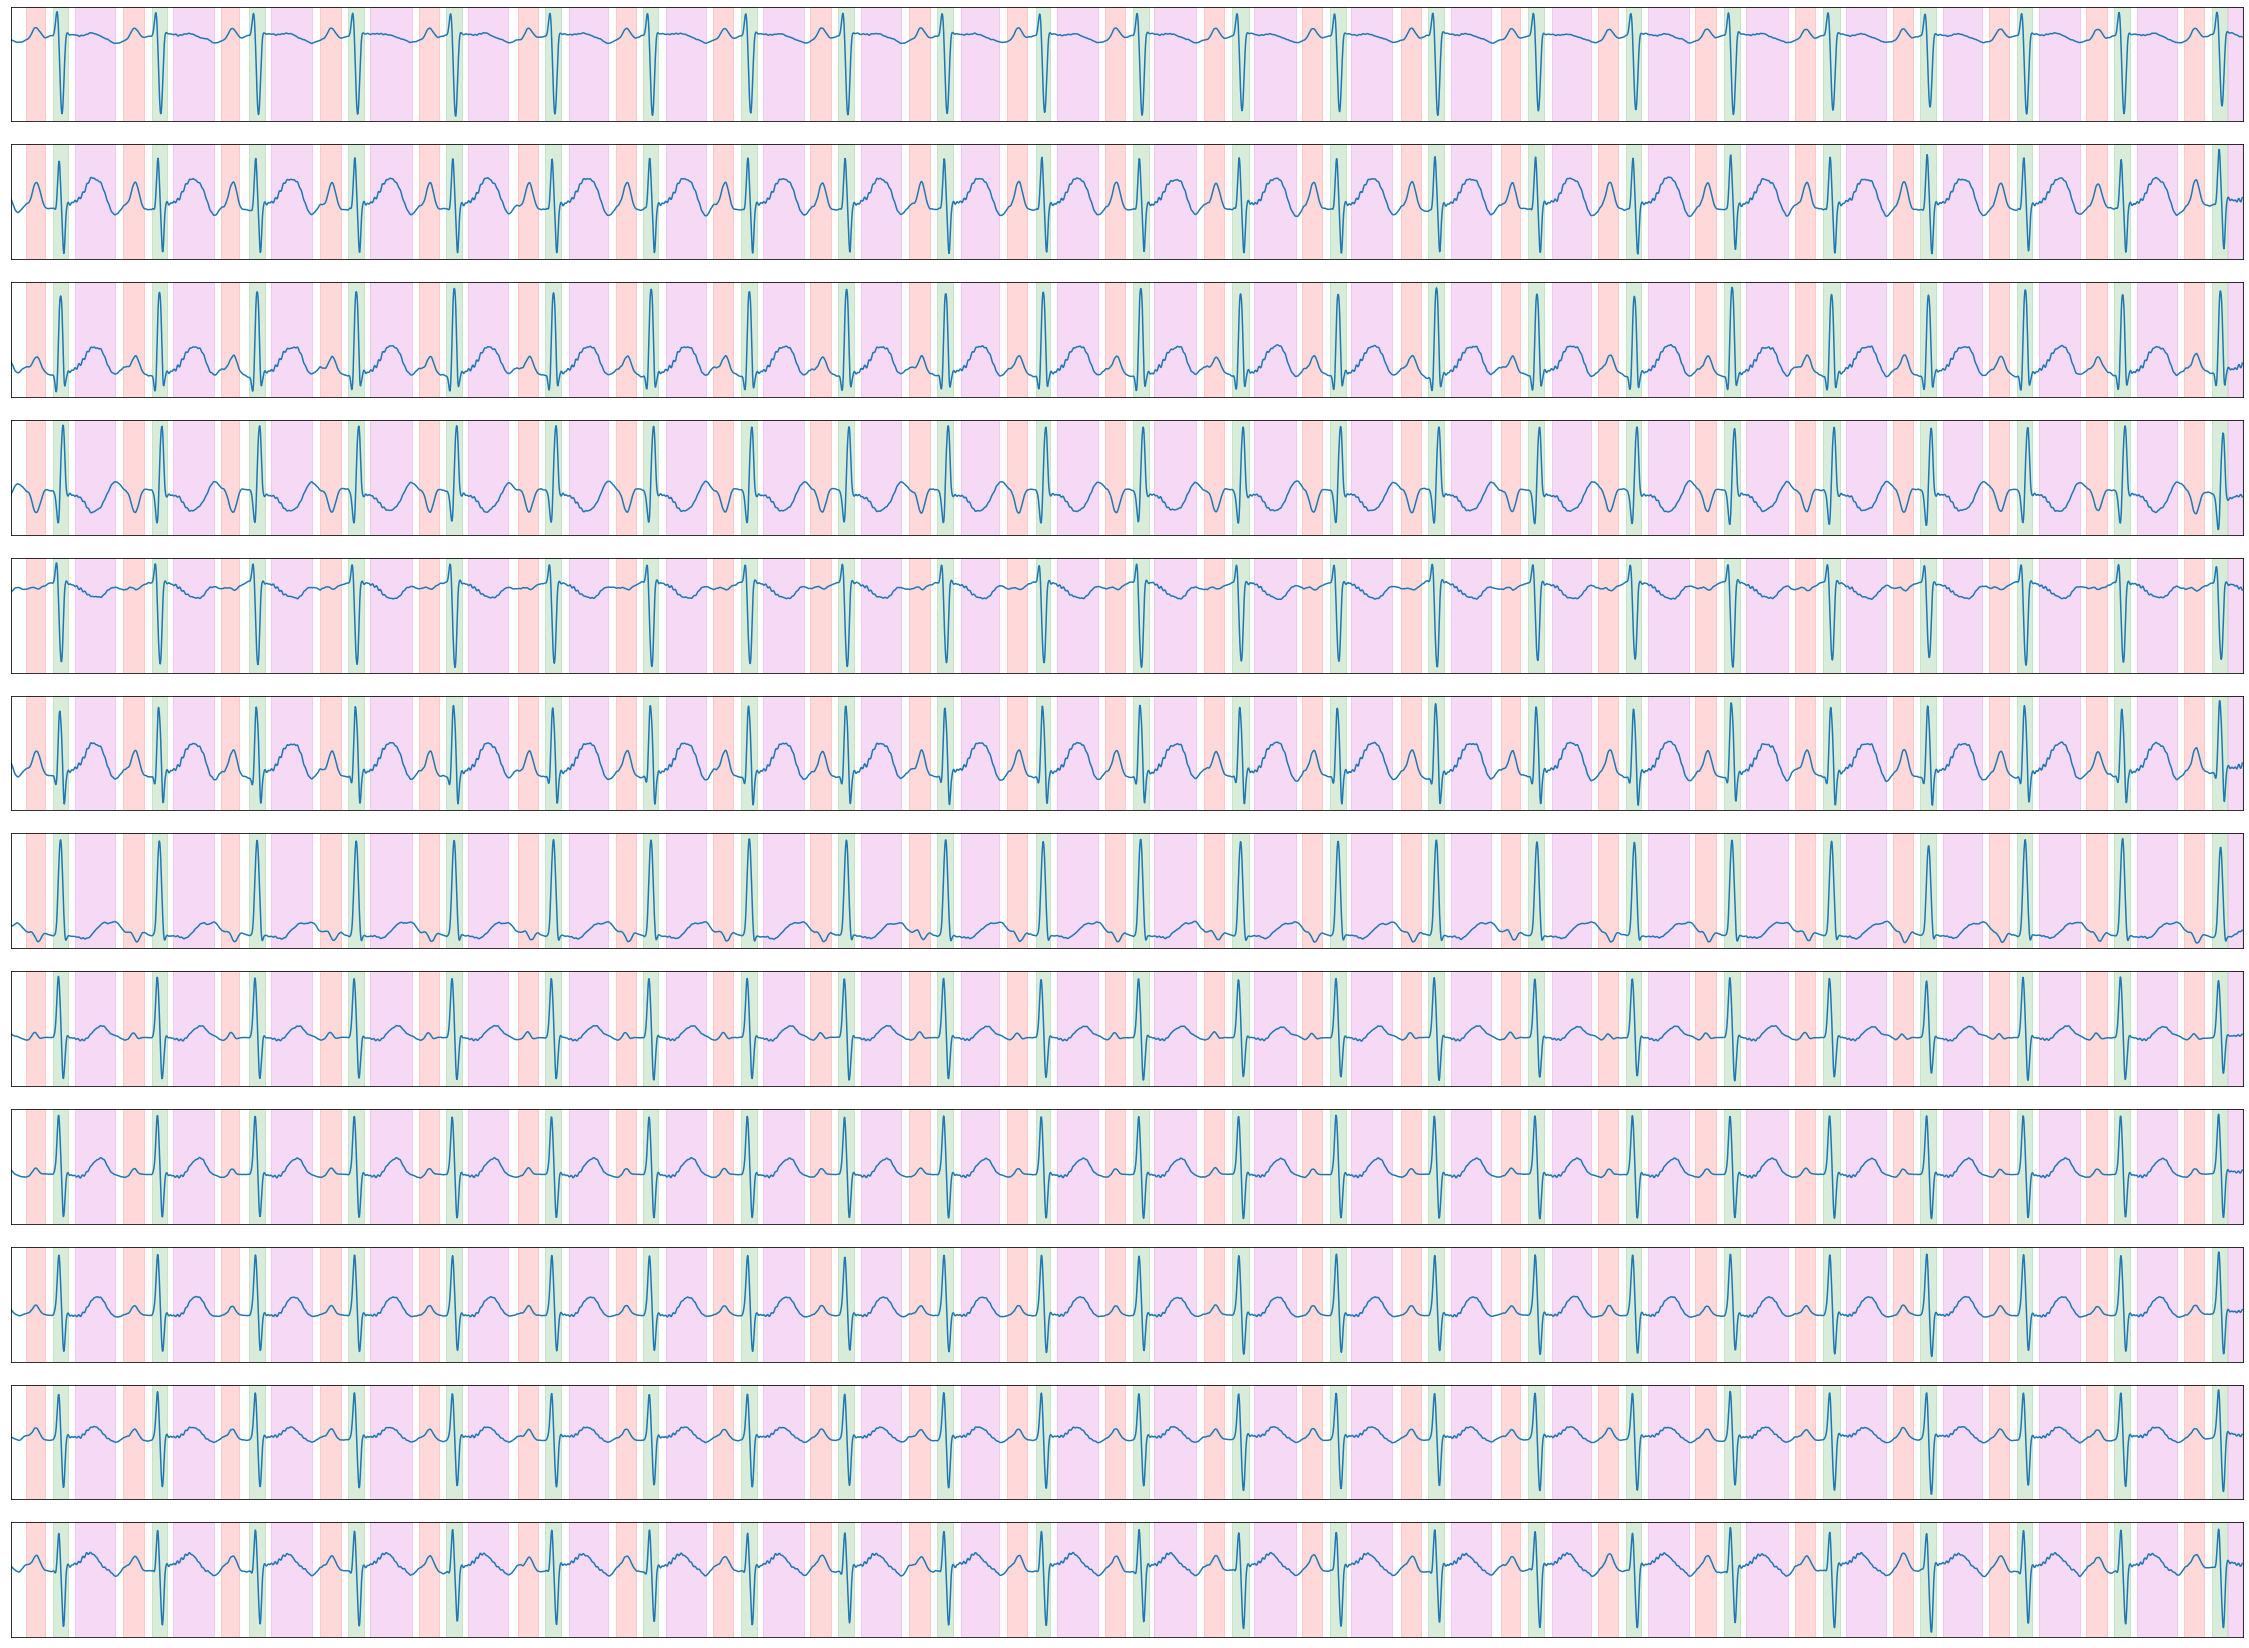

In [35]:
import xml.etree.ElementTree as ET

tree = ET.parse(list_files[3])

fs = float(tree.findall("StripData/SampleRate")[0].text)
ecg = {}
for lead in tree.findall("StripData/WaveformData"):
    ecg[lead.get("lead").upper()] = np.array(lead.text.strip().split(","),dtype=int)
ecg = np.array([ecg[k] for k in StandardHeader])
ecg = sp.signal.filtfilt(*sp.signal.butter(2,   5.0/fs, 'high'),ecg,axis=-1)
ecg = sp.signal.filtfilt(*sp.signal.butter(2, 150.0/fs,  'low'),ecg,axis=-1)
ecg = sp.signal.lfilter(*sp.signal.iirnotch(50,20.0,fs),ecg,axis=-1)
ecg = sp.signal.lfilter(*sp.signal.iirnotch(60,20.0,fs),ecg,axis=-1)
ecg_175 = sak.signal.interpolate.interp1d(ecg,round(ecg.shape[1]*175/fs))
ecg_250 = sak.signal.interpolate.interp1d(ecg,round(ecg.shape[1]*250/fs))
segmentation_175 = predict_ECG(ecg_175,models_ECG,normalize=True)
segmentation_250 = predict_ECG(ecg_250,models_ECG,normalize=True)
segmentation      = sak.signal.interpolate.interp1d(segmentation_250,ecg.shape[1],axis=-1,kind="nearest")
# segmentation[-1,] = sak.signal.interpolate.interp1d(segmentation_175[-1],ecg.shape[1],kind="nearest")

pon,poff = np.array(sak.signal.get_mask_boundary(segmentation[0,:]))
qon,qoff = np.array(sak.signal.get_mask_boundary(segmentation[1,:]))
ton,toff = np.array(sak.signal.get_mask_boundary(segmentation[2,:]))

f,ax = plt.subplots(nrows=12,figsize=(40,30))

for i,(lead,a) in enumerate(zip(ecg,ax)):
    a.plot(lead);a.set_xticks([]);a.set_yticks([]);
    a.set_xlim([0,ecg.shape[-1]])
    
    for on,off in zip(pon,poff):
        a.axvspan(on,off,color="r",alpha=0.15)
    for on,off in zip(qon,qoff):
        a.axvspan(on,off,color="g",alpha=0.15)
    for on,off in zip(ton,toff):
        a.axvspan(on,off,color="m",alpha=0.15)
        

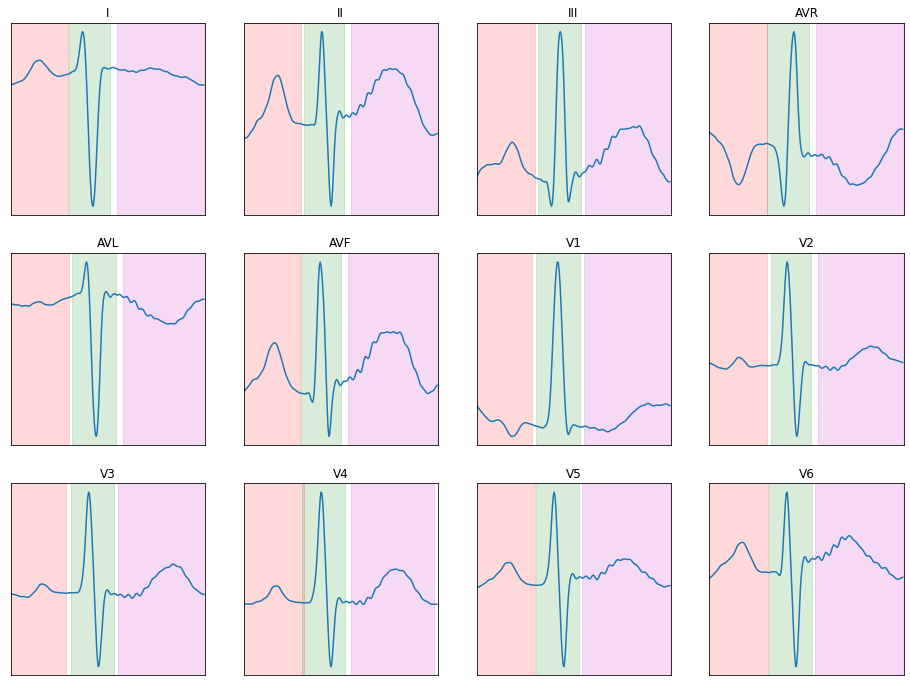

In [34]:
f,ax = plt.subplots(nrows=3,ncols=4,figsize=(16,12))
ax = ax.flatten()

for i,(lead,a) in enumerate(zip(ecg,ax)):
    list_pairwise = list(sak.pairwise(pon))
    s_on,s_off = list_pairwise[np.random.randint(len(list_pairwise))]
    a.plot(np.arange(s_on,s_off),lead[s_on:s_off]);a.set_xticks([]);a.set_yticks([]);
    a.set_xlim([s_on,s_off])
    
    for on,off in zip(pon,poff):
        if (on >= s_on-10 and off <= s_off+10):
            a.axvspan(on,off,color="r",alpha=0.15)
    for on,off in zip(qon,qoff):
        if (on >= s_on-10 and off <= s_off+10):
            a.axvspan(on,off,color="g",alpha=0.15)
    for on,off in zip(ton,toff):
        if (on >= s_on-10 and off <= s_off+10):
            a.axvspan(on,off,color="m",alpha=0.15)
       
    a.set_title(StandardHeader[i])